In [2]:
import json
import math
import bigfloat
import numpy
import pandas as pd
import seaborn as sns
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from collections import OrderedDict

import seaborn as sns
sns.set_style("whitegrid", {"font.family": "DejaVu Sans"})
sns.set_context("poster")

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [8]:
    def read_data(filename, short=False):
        json_data = open(filename, 'r').read()
        raw_data = json.loads(json_data)
        seq = []
        seq_id = []
        energy = []
        for k1, v1 in raw_data.iteritems():
            if k1 == "name":
                continue
            stp_i = int(k1)
            staple = v1
            #print str(stp_i) + ' ' + v1['staple_sequence']
            for k2, v2 in staple.iteritems():
                if not k2.isdigit():
                    continue
                arm_i = k2
                arm = v2
                #if short and len(arm['sequence']) > 8:
                #    continue
                dG = arm['dG']
                min_dG = float(arm['min_dG'])
                seq.append(arm['sequence'])
                seq_id.append('stp_' + str(stp_i) + '_' + str(arm_i))
                local_min = []
                for i in range(len(dG)-1):
                    if dG[i] < dG[i-1] and dG[i] <= dG[i+1]:
                        local_min.append(float(dG[i]))
                sorted_by_energy = sorted(local_min)
                energy.append(numpy.array(sorted_by_energy))
        return seq_id, seq, energy

In [8]:
def get_boltzmann_distribution(energy_by_arm):
    R = 8.3144621  # gas constant
    T = 293.15  # room temperature
    factor = 4184.0  # joules_per_kcal
    boltzmann_distribution = []
    for dG in energy_by_arm:
        ps = []
        total = bigfloat.BigFloat(0)
        for energy in dG:
            p = bigfloat.exp((-energy*factor)/(R*T), bigfloat.precision(1000))
            ps.append(p)
            total = bigfloat.add(total, p)
        normal_ps = []
        for p in ps:
            normal_ps.append(float(bigfloat.div(p,total)))
        boltzmann_distribution.append(numpy.array(normal_ps))
    return boltzmann_distribution

In [102]:
path = 'data/'
filename_DB = 'DeBruijn_alpha.json'
filename_pUC19 = 'pUC19_alpha.json'
filename_M13 = 'M13_square.json'
filename_DB7k = 'DB_7k_square.json'

#ids, sequences, energies
#_, _, energies_DB = read_data(path + filename_DB)
#_, _, energies_pUC19 = read_data(path + filename_pUC19)
#_, _, energies_M13 = read_data(path + filename_M13)

_, _, energies_DB_short = read_data(path + filename_DB, short=True)
_, _, energies_pUC19_short = read_data(path + filename_pUC19, short=True)
_, _, energies_M13_short = read_data(path + filename_M13, short=True)
_, _, energies_DB7k_short = read_data(path + filename_DB7k, short=True)

#DB_dist_2 = get_boltzmann_distribution(d[:2] for d in energies_DB_short)
#pUC19_dist_2 = get_boltzmann_distribution(d[:2] for d in energies_pUC19_short)
#M13_dist_2 = get_boltzmann_distribution(d[:2] for d in energies_M13_short)

#DB_dist_10 = get_boltzmann_distribution(d[:10] for d in energies_DB_short)
#pUC19_dist_10 = get_boltzmann_distribution(d[:10] for d in energies_pUC19_short)
#M13_dist_10 = get_boltzmann_distribution(d[:10] for d in energies_M13_short)

#DB_dist_100 = get_boltzmann_distribution(d[:100] for d in energies_DB_short)
#pUC19_dist_100 = get_boltzmann_distribution(d[:100] for d in energies_pUC19_short)
#M13_dist_100 = get_boltzmann_distribution(d[:100] for d in energies_M13_short)

DB_dist_all = get_boltzmann_distribution(d for d in energies_DB_short)
pUC19_dist_all = get_boltzmann_distribution(d for d in energies_pUC19_short)
M13_dist_all = get_boltzmann_distribution(d for d in energies_M13_short)
DB7k_dist_all = get_boltzmann_distribution(d for d in energies_DB7k_short)

#DB_dist = get_boltzmann_distribution(d[:100] for d in energies_DB_short)
#pUC19_dist = get_boltzmann_distribution(d[:100] for d in energies_pUC19_short)
#M13_dist = get_boltzmann_distribution(d[:100] for d in energies_M13_short)

#DB_dist = get_boltzmann_distribution(energies_DB_short)
#pUC19_dist = get_boltzmann_distribution(energies_pUC19_short)

#dist = [d[0] for d in DB_dist]

In [6]:
def example_plot(ax, fontsize=12):
     ax.plot([1, 2])
     ax.locator_params(nbins=3)
     ax.set_xlabel('x-label', fontsize=fontsize)
     ax.set_ylabel('y-label', fontsize=fontsize)
     ax.set_title('Title', fontsize=fontsize)

In [105]:
def distribution_plot(ax, data_label, data, xlabel, ylabel, fontsize=15):
    bins = 20
    x = numpy.zeros(bins)
    for dist in data:
        i = int(dist[0]*bins)
        i = 0 if i < 0 else i
        i = bins-1 if i > bins-1 else i
        x[i] += 1
    for i in range(len(x)):
        x[i] = 1.0 * x[i] / len(data)
    index = numpy.arange(0, bins)
    ax.bar(index, x, bar_width, linewidth=0)
    ax.set_xticks(numpy.arange(0, bins+1))
    ax.set_xticklabels([('$' + str(i*0.05) + '$') if i % 2 == 0 else "" for i in range(0, bins+1)])
    #ax.tick_params(axis='both', which='major')
    
    ylimit = 0.2 if ('6.9' in data_label or 'M13' in data_label) else 0.3
    ax.set_xlim(0, bins)
    ax.set_ylim(0, ylimit)
    
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_title(data_label, fontsize=20)
    ax.legend()
    

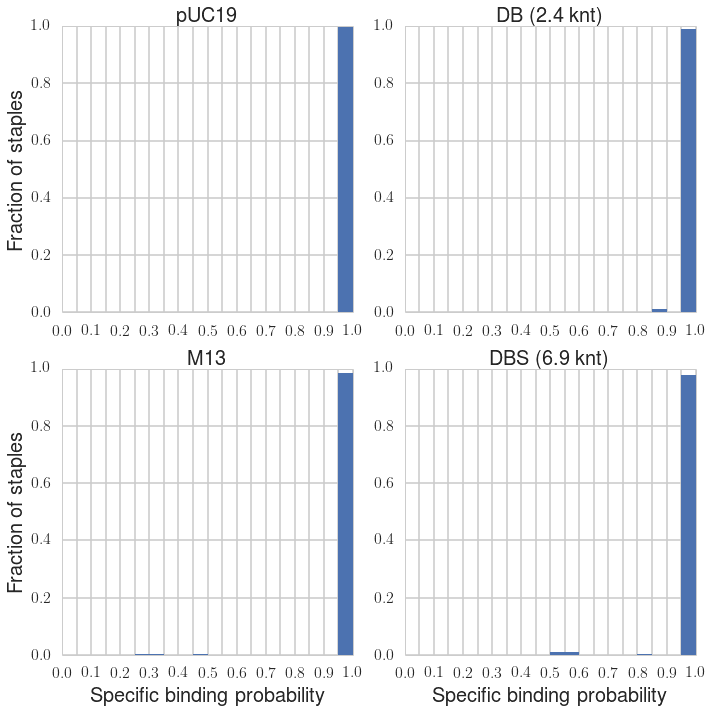

In [106]:
plt.close('all')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

data_set = OrderedDict()
data_set['pUC19 (all)'] = pUC19_dist_all
data_set['DB (all)'] = DB_dist_all
data_set['M13 (all)'] = M13_dist_all
data_set['DB7k (all)'] = DB7k_dist_all

xlabel = r'Specific binding probability'
ylabel = r'Fraction of staples'

distribution_plot(ax1, r'pUC19', pUC19_dist_all, '', ylabel)
distribution_plot(ax2, r'DB (2.4 knt)', DB_dist_all, '', '')
distribution_plot(ax3, r'M13', M13_dist_all, xlabel, ylabel)
distribution_plot(ax4, r'DBS (6.9 knt)', DB7k_dist_all, xlabel, '')

#%matplotlib inline

fig.set_size_inches(10, 10)

plt.tight_layout()
plt.savefig("/home/j3ny/repos/analysis/Analysis/thermodynamic_addressability/output/addressability_comparison.pdf",format='pdf',dpi=600)
#plt.savefig("/home/j3ny/repos/analysis/Analysis/thermodynamic_addressability/output/addressability_comparison_long.pdf",format='pdf',dpi=600)


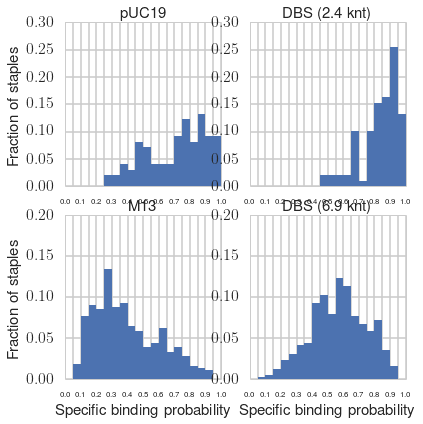

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=2)

bar_width = 1.0

data_set = OrderedDict()
data_set['pUC19'] = pUC19_dist_all
data_set['DBS (2.4 knt)'] = DB_dist_all
data_set['M13'] = M13_dist_all
data_set['DBS (6.9 knt)'] = DB7k_dist_all

plt.close('all')
fig = plt.figure()

from mpl_toolkits.axes_grid1 import Grid
grid = Grid(fig, rect=111, nrows_ncols=(2,2),
            axes_pad=0.4, label_mode='O',
            add_all = True,
            )

for ax, (data_label, data) in zip(grid, data_set.items()):
    xlabel = 'Specific binding probability' if ('6.9' in data_label or 'M13' in data_label) else ''
    ylabel = 'Fraction of staples'if ('pUC' in data_label or 'M13' in data_label) else ''
    distribution_plot(ax, data_label, data, xlabel, ylabel)

#axes[0,0].set_title('pUC19')
    
#grid[0].set_title('pUC19')
#grid[0].set_ylabel('Fraction of staples', fontsize=15)
#grid[1].set_title('DBS (2.4 knt)')

#grid[2].set_title('M13')
#grid[2].set_xlabel('Specific binding probability', fontsize=15)
#grid[2].set_ylabel('Fraction of staples', fontsize=15)

#grid[3].set_title('DBS (6.9 knt)')

#axes[1].set_title('M13')
#axes[2].set_title(r'$\lambda$-phage')

#fig.text(0.16, 0.92, 'pUC19', fontsize=15)
#fig.text(0.6, 0.92, 'DBS (2.4 knt)', fontsize=15)

#fig.text(0.16, 0.46, 'M13mp18', fontsize=15)
#fig.text(0.6, 0.46, 'DBS (6.9 knt)', fontsize=15)

fig.set_size_inches(6, 6)

plt.tight_layout()
plt.savefig("/home/j3ny/repos/analysis/Analysis/thermodynamic_addressability/output/addressability_comparison.pdf",format='pdf',dpi=600)

TypeError: distribution_plot() takes at least 5 arguments (1 given)

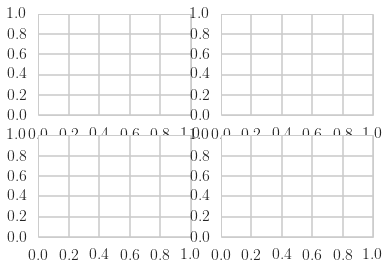

In [44]:
#######################
##     OBSOLETE    ##
#######################

#%matplotlib inline

fig, axes = plt.subplots(nrows=2, ncols=2)

bar_width = 1.0

data_set = OrderedDict()
data_set['pUC19 (all)'] = pUC19_dist_all
data_set['DB (all)'] = DB_dist_all
data_set['M13 (all)'] = M13_dist_all
data_set['DB7k (all)'] = DB7k_dist_all

for ax0, (data_label, data) in zip(axes.flat, data_set.items()):
    distribution_plot(ax0)

#fig.text(0.19, 0.96, 'De Bruijn', ha='center')
fig.text(0.3, 1, 'pUC19 (2.6 knt)', ha='center')
fig.text(0.7, 1, 'DBS (2.4 knt)', ha='center')

fig.text(0.5, 0.008, 'Specific binding probability', ha='center')
fig.text(0.001, 0.5, 'Fraction of staples', va='center', rotation='vertical')

fig.set_size_inches(7, 7)

plt.tight_layout()
plt.savefig("/home/j3ny/repos/analysis/Analysis/thermodynamic_addressability/output/addressability_comparison.pdf",format='pdf',dpi=600)

In [20]:
## CONVERT DATA

path = 'data/'
filename_DB = 'DeBruijn_alpha.json'
filename_pUC19 = 'pUC19_alpha.json'
filename_M13 = 'M13_square.json'
filename_DB7k = 'DB_7k_square.json'

ids, sequences, energies = read_data(path + filename_DB7k, short=True)
dist_all = get_boltzmann_distribution(d for d in energies)

with open('data/DB_medium.csv', 'w') as out:
    for i in range(len(ids)):
        out.write(ids[i] + ',' + sequences[i] + ',')
        out.write('%.3f' % dist_all[i][0])
        out.write('\n')
    #print idsi], sequences[i], energies_DB_short[i], DB_dist_all[i]